In [19]:
# Imports
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [89]:
# Functions definitions
def read_trapezoidal():
    df = pd.read_csv('../data/external/trapezoidal_kc.csv',
                     sep=';', decimal=',',
                     index_col=0,
                     parse_dates=True, 
                     infer_datetime_format=True, dayfirst=True,
                     skiprows=[0],
                     header = 0,
                     names=['Allen', 'Rallo'],
    )
    df.index.name = 'Day'
    return df

def read_measures():
    df = pd.read_pickle('../data/interim/data.pickle')
    return df.loc[:, ['ETa', 'ETo']].dropna()

def read_kcvi():
    df = pd.read_csv('../data/external/VIs_Kc_2018_2022.csv',
                     sep=';', decimal=',',
                     index_col=0,
                     parse_dates=True, 
                     infer_datetime_format=True, dayfirst=True,
                     header = 0,
                     names = ['Kc_VIs']
    )
    df.index.name = 'Day'
    return df

def read_all_data():
    predicted_kc = pd.read_csv('../data/predicted/postprocessed.csv', parse_dates=True, infer_datetime_format=True, index_col=0)
    predicted_trapezoidal = pd.read_pickle('../data/predicted/trapezoidal.pickle')
    theoretical = read_trapezoidal()
    kcvi = read_kcvi()
    return [predicted_kc, predicted_trapezoidal, theoretical, kcvi]

# Crop Coefficient Data

In [90]:
data = pd.concat(read_all_data(), axis=1, join='outer')
data

,Kc,Source,trapezoidal,std,Allen,Rallo,Kc_VIs
Day,,,,,,,
2018-01-01,NaN,NaN,NaN,NaN,0.9,0.65,NaN
2018-01-02,NaN,NaN,NaN,NaN,0.9,0.65,NaN
2018-01-03,NaN,NaN,NaN,NaN,0.9,0.65,NaN
2018-01-04,NaN,NaN,NaN,NaN,0.9,0.65,NaN
2018-01-05,NaN,NaN,NaN,NaN,0.9,0.65,NaN
...,...,...,...,...,...,...,...
2022-09-28,0.682848,Measured,NaN,NaN,NaN,NaN,0.49
2022-09-29,0.669290,Measured,NaN,NaN,NaN,NaN,0.49
2022-09-30,0.587009,Measured,NaN,NaN,NaN,NaN,0.51


## Measures and VI predictions
A comparison

In [22]:
kc_measured = data.loc[data['Source']=='Measured', ['Kc', 'Kc_VIs']]
r2 = r2_score(kc_measured['Kc'], kc_measured['Kc_VIs'])
rmse = mean_squared_error(kc_measured['Kc'], kc_measured['Kc_VIs'], squared=False)

et_measures = read_measures()
eta_vi = kc_measured['Kc_VIs'] * et_measures['ETo']
eta = et_measures.loc[eta_vi.dropna().index, 'ETa']
r2_eta = r2_score(eta, eta_vi.dropna())
print(f'R2 score ETa measured / ETa VI: {r2_eta}')

R2 score ETa measured / ETa VI: 0.5616356559597484


(0.45, 1.4)

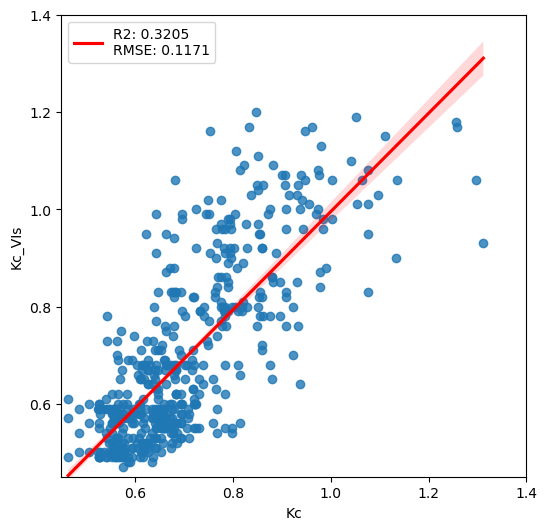

In [23]:
# Regression Plot
fig, ax = plt.subplots(figsize=(6, 6))
ax = sns.regplot(
    kc_measured, 
    x='Kc', 
    y='Kc_VIs',
    robust=True,
    ci=80,
    line_kws={'label':f"R2: {r2:.4}\nRMSE: {rmse:.4}", 'color':"red"},
    ax=ax
)
ax.legend(loc='upper left')
ax.set_ylim(0.45, 1.4)
ax.set_xlim(0.45, 1.4)

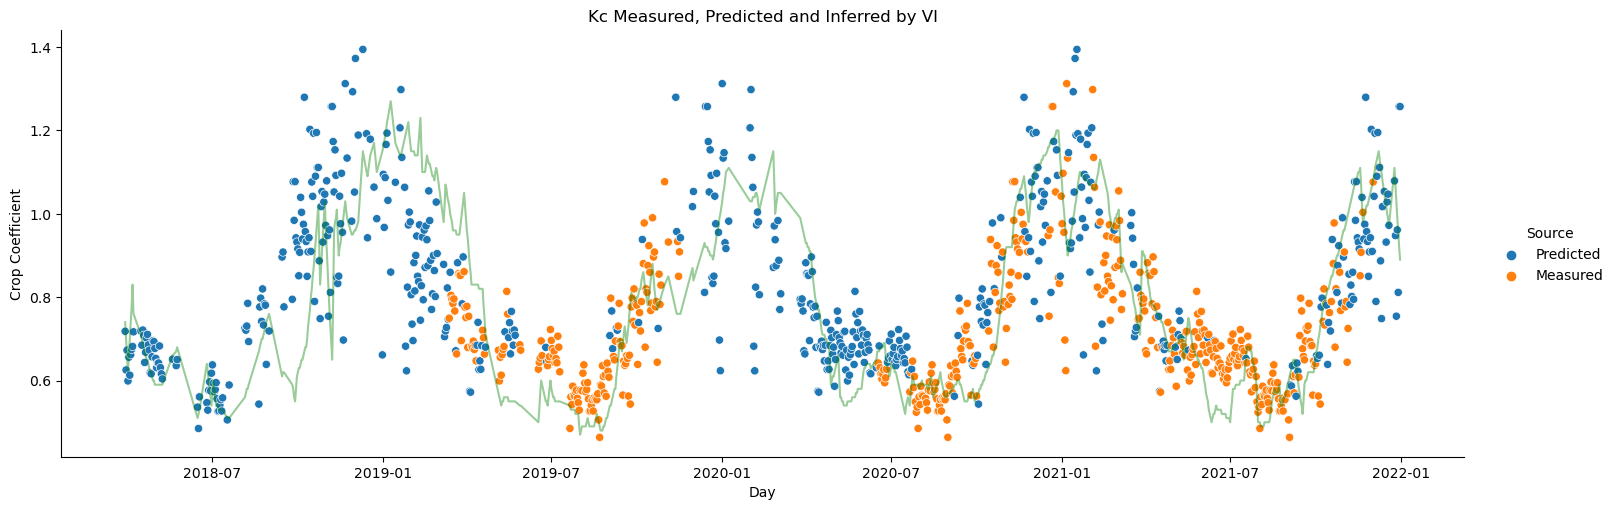

In [24]:
g = sns.relplot(
    data, 
    x='Day', 
    y='Kc', 
    hue='Source',
    aspect=3,
)
g.map(sns.lineplot, 'Day', 'Kc_VIs', color='green', alpha=0.4)
g.set_ylabels('Crop Coefficient').set(title='Kc Measured, Predicted and Inferred by VI')

In [25]:
data

,Kc,Source,trapezoidal,std,Allen,Rallo,Kc_VIs
Day,,,,,,,
2018-03-29,0.718089,Predicted,0.747224,0.104763,0.900,0.650,0.74
2018-03-30,0.625327,Predicted,0.747224,0.104763,0.900,0.650,0.70
2018-03-31,0.672771,Predicted,0.747224,0.104763,0.900,0.650,0.66
2018-04-01,0.599060,Predicted,NaN,NaN,0.889,0.645,0.62
2018-04-02,0.655984,Predicted,NaN,NaN,0.877,0.640,0.66
...,...,...,...,...,...,...,...
2021-12-27,0.754360,Predicted,0.908670,0.159813,0.900,0.650,1.03
2021-12-28,0.961324,Predicted,0.908670,0.159813,0.900,0.650,0.99
2021-12-29,0.811427,Predicted,0.908670,0.159813,0.900,0.650,0.96


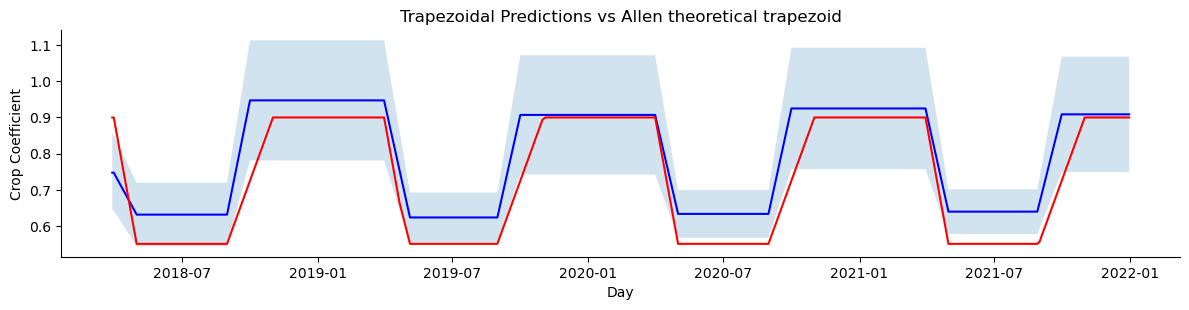

In [26]:
g = sns.FacetGrid(data.reset_index(),
                 aspect=4)
g.map(sns.lineplot, 'Day', 'trapezoidal', color='blue')
g.map(sns.lineplot, 'Day', 'Allen', color='red')
g.set(title='Trapezoidal Predictions vs Allen theoretical trapezoid').set_ylabels('Crop Coefficient')
low_trpz = data['trapezoidal'].dropna()-data['std'].dropna()
high_trpz = data['trapezoidal'].dropna()+data['std'].dropna()
g.ax.fill_between(data.dropna().index, low_trpz, high_trpz, alpha=0.2)

## Mean Squared Error
Average distance between Measured/Predicted data and theoretical Allen trapezoid or VI inferred

In [28]:
mse_allen = mean_squared_error(data['Kc'], data['Allen'], squared=False)
mse_vi = mean_squared_error(data['Kc'], data['Kc_VIs'], squared=False)
print(f'Computed Mean Squared Error (ALLEN): {mse_allen}')
print(f'Computed Mean Squared Error (VI): {mse_vi}')

Computed Mean Squared Error (ALLEN): 0.13692918328089215
Computed Mean Squared Error (VI): 0.15203815531719914


## Relative Error
Plotting the relative error of each point, 
given by the ratio of the measure and the error

In [141]:
import numpy as np
#data['Allen_Errors'] = mse_allen / data['Kc']
#data['VI_Errors'] = mse_vi / data['Kc']
data['Allen_Errors'] = (data['Kc'].values - data['Allen'].values) / data['Kc'].values
data['VI_Errors'] = (data['Kc'].values - data['Kc_VIs'].values) / data['Kc'].values

### Allen Errors

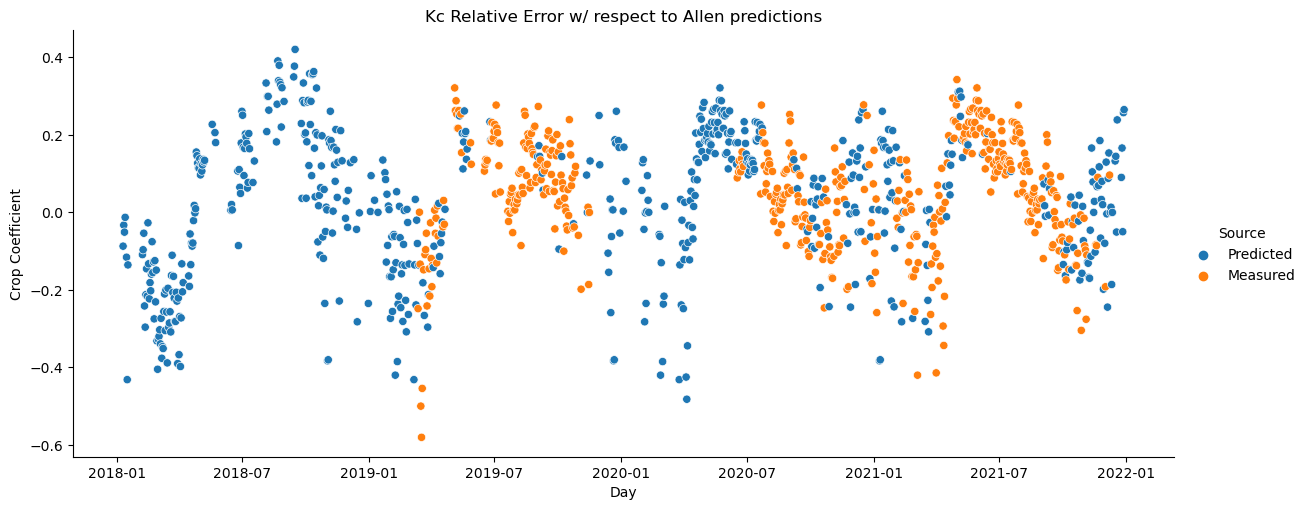

In [142]:

g = sns.relplot(
    data,
    x='Day',
    y='Allen_Errors',
    hue='Source',
    aspect=2.4,
)
g.set(title='Kc Relative Error w/ respect to Allen predictions').set_ylabels('Crop Coefficient')

### VI Errors

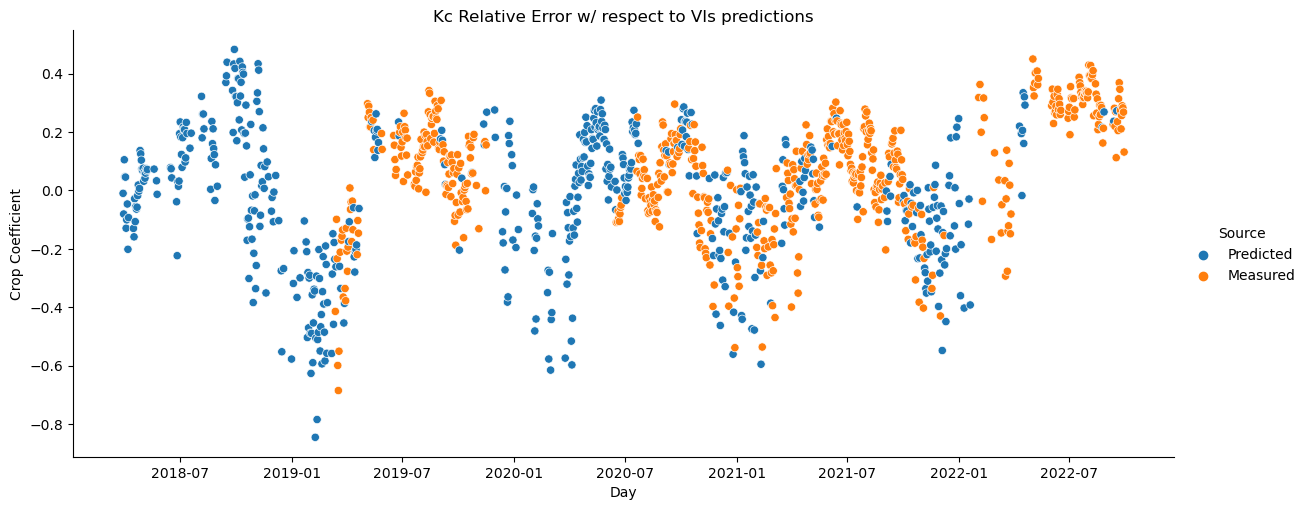

In [143]:
g = sns.relplot(
    data,
    x='Day',
    y='VI_Errors',
    hue='Source',
    aspect=2.4,
)
g.set(title='Kc Relative Error w/ respect to VIs predictions').set_ylabels('Crop Coefficient')

## Distributions

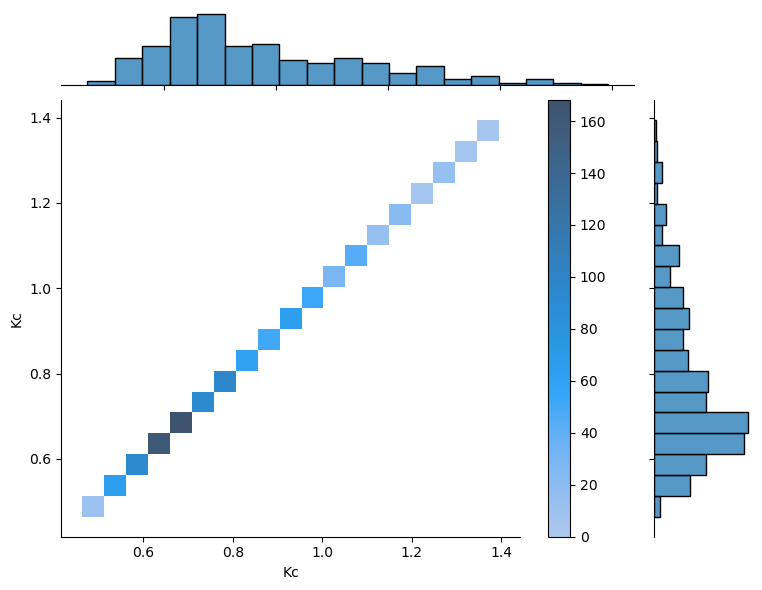

In [40]:
g = sns.jointplot(data, 
    x='Kc', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)

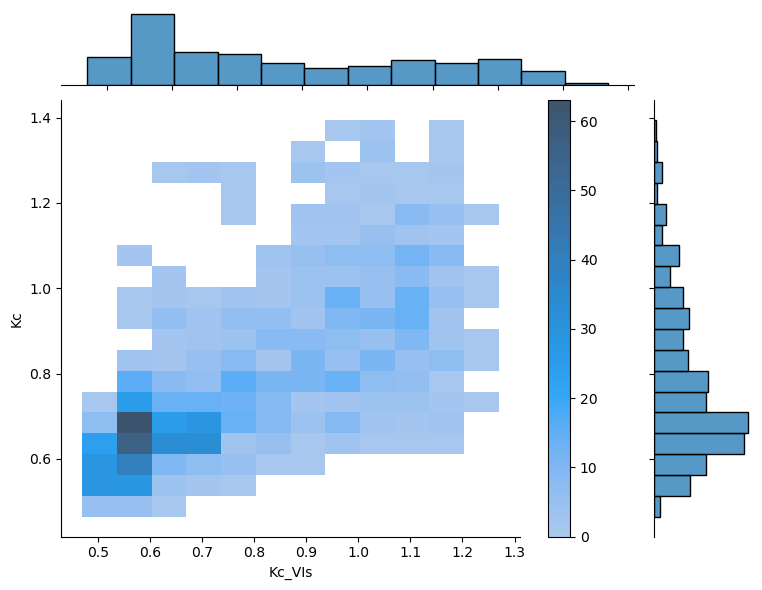

In [41]:
g = sns.jointplot(data, 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8) 

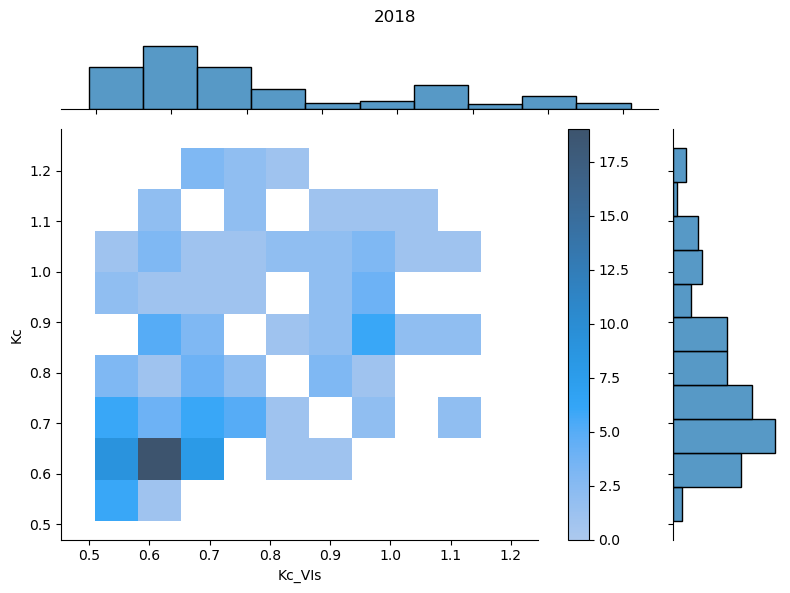

In [130]:
g = sns.jointplot(data.loc['2018'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('2018')
g.fig.tight_layout()

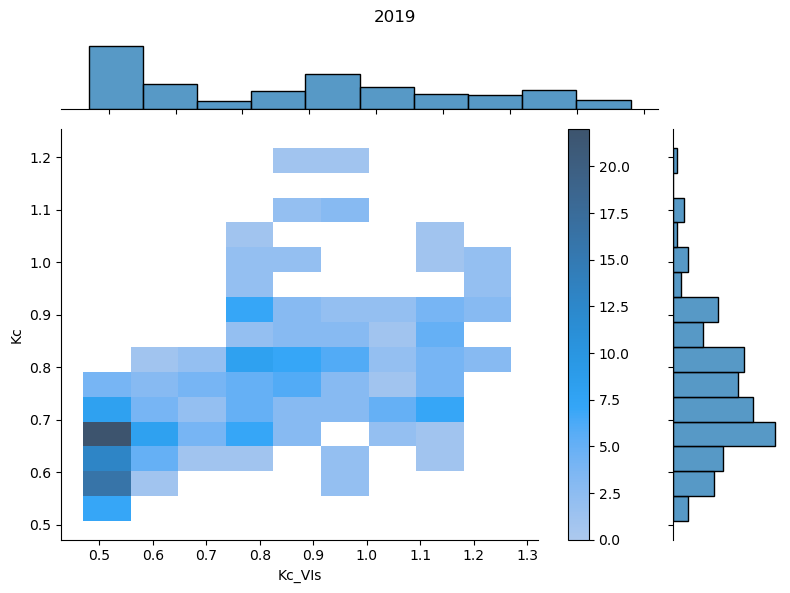

In [129]:
g = sns.jointplot(data.loc['2019'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('2019')
g.fig.tight_layout()

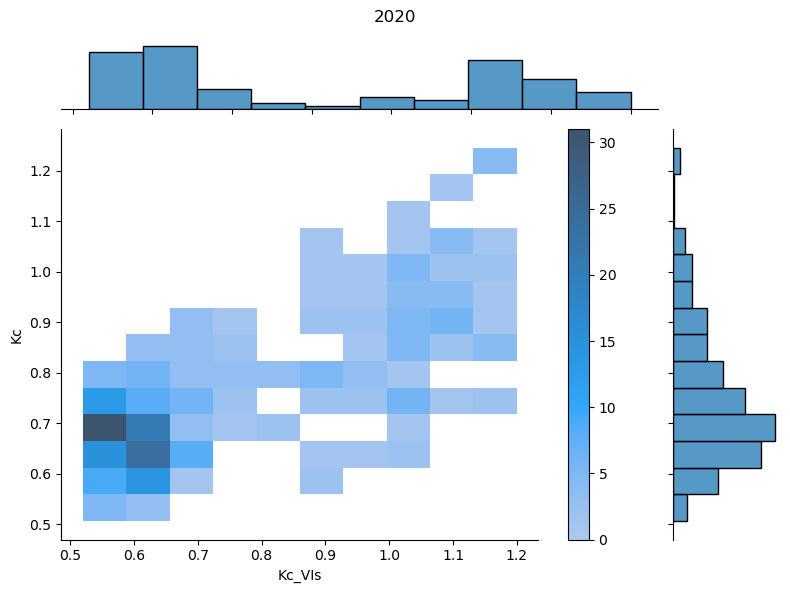

In [128]:
g = sns.jointplot(data.loc['2020'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('2020')
g.fig.tight_layout()

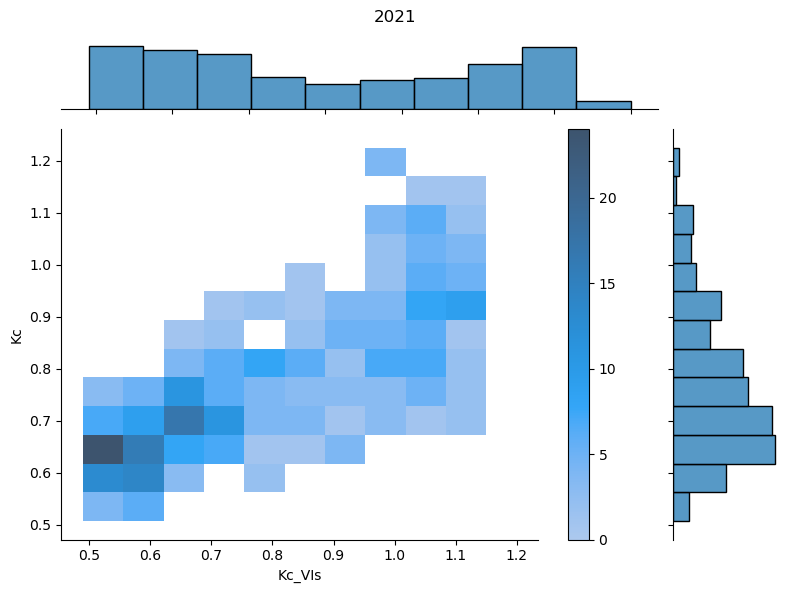

In [127]:
g = sns.jointplot(data.loc['2021'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('2021')
g.fig.tight_layout()

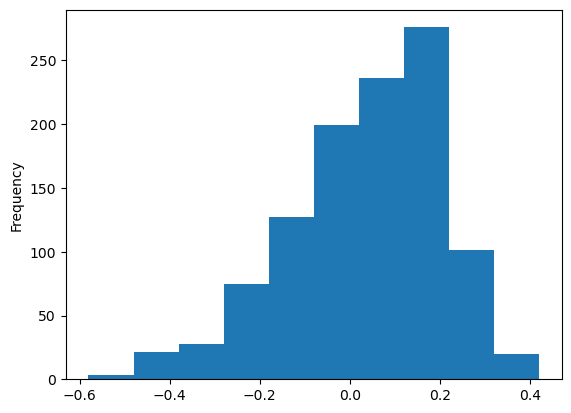

In [146]:
data['Allen_Errors'].plot(kind='hist')
plt.show()

### Seasons

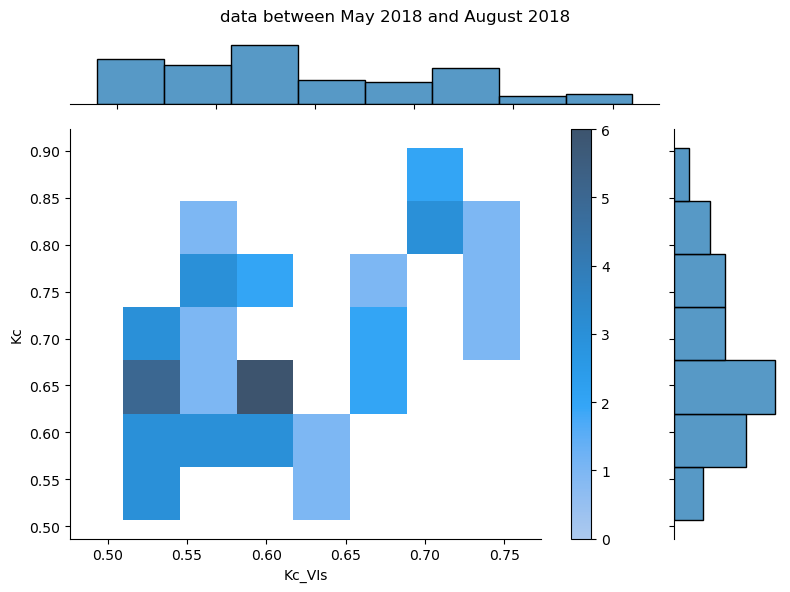

In [126]:
g = sns.jointplot(data.loc['2018-05':'2018-08'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('data between May 2018 and August 2018')
g.fig.tight_layout()

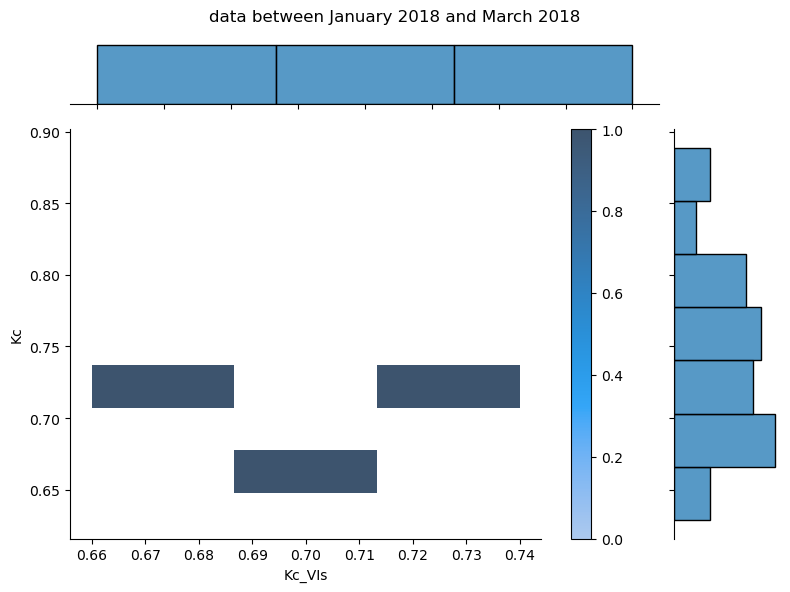

In [125]:
g = sns.jointplot(data.loc['2018-01':'2018-03'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('data between January 2018 and March 2018')
g.fig.tight_layout()

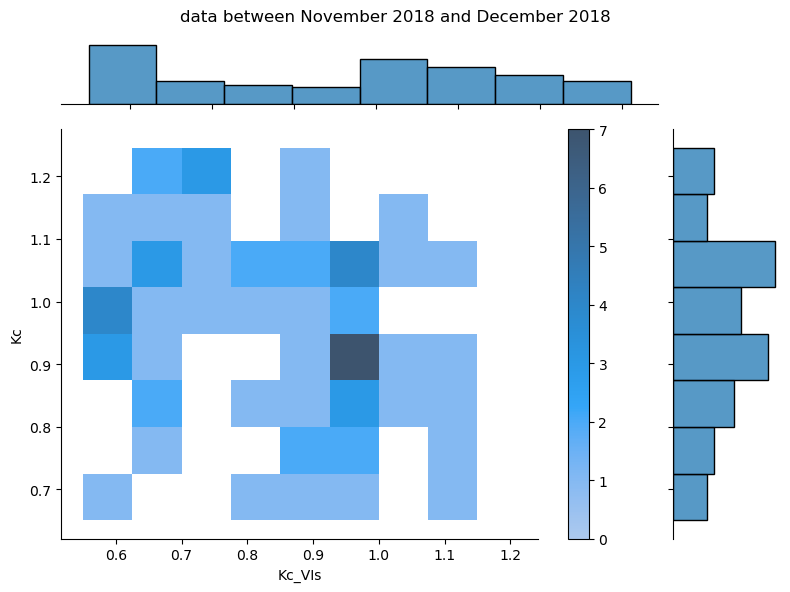

In [124]:
g = sns.jointplot(data.loc['2018-09':'2018-12'], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('data between November 2018 and December 2018')
g.fig.tight_layout()

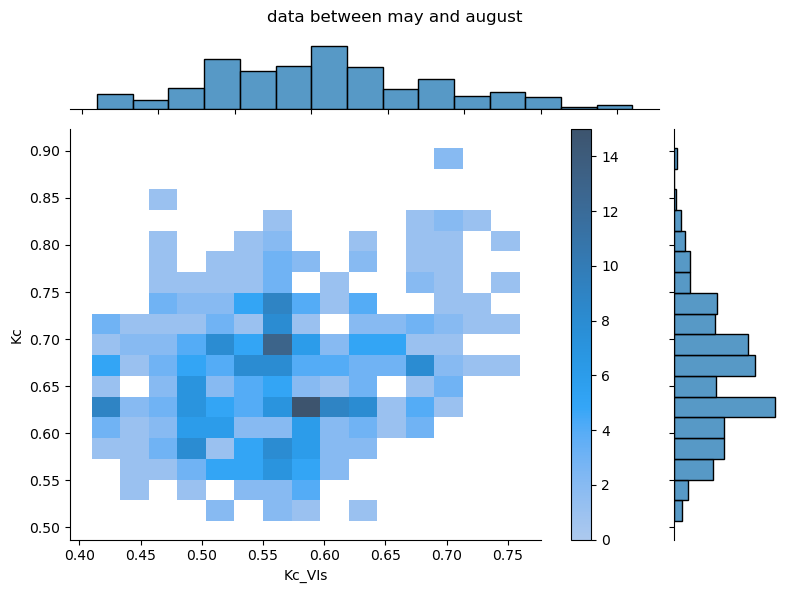

In [118]:
g = sns.jointplot(data[(data.index.month < 9) & (data.index.month > 4)], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('data between May and August')
g.fig.tight_layout()

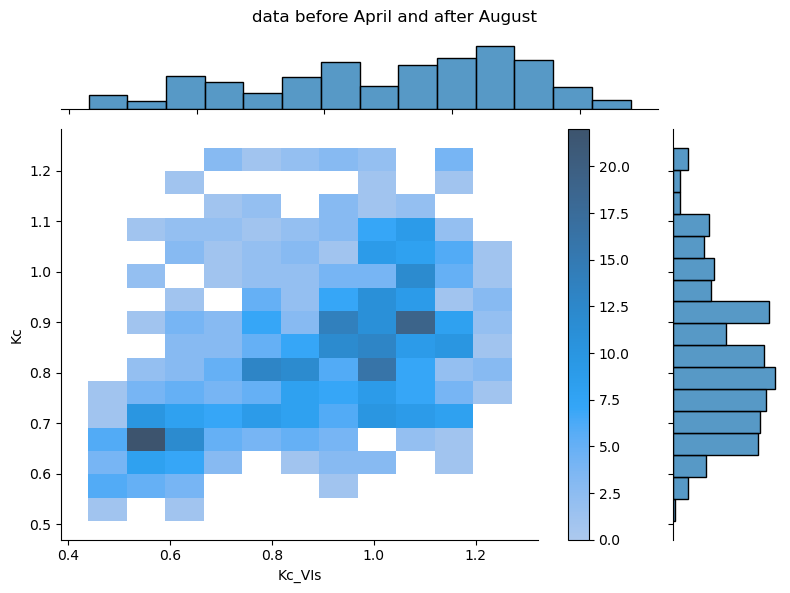

In [123]:
g = sns.jointplot(data[(data.index.month < 4) | (data.index.month > 8)], 
    x='Kc_VIs', 
    y='Kc',
    kind='hist',
    cbar=True
)
g.fig.set_figwidth(8)
g.fig.suptitle('data before April and after August')
g.fig.tight_layout()

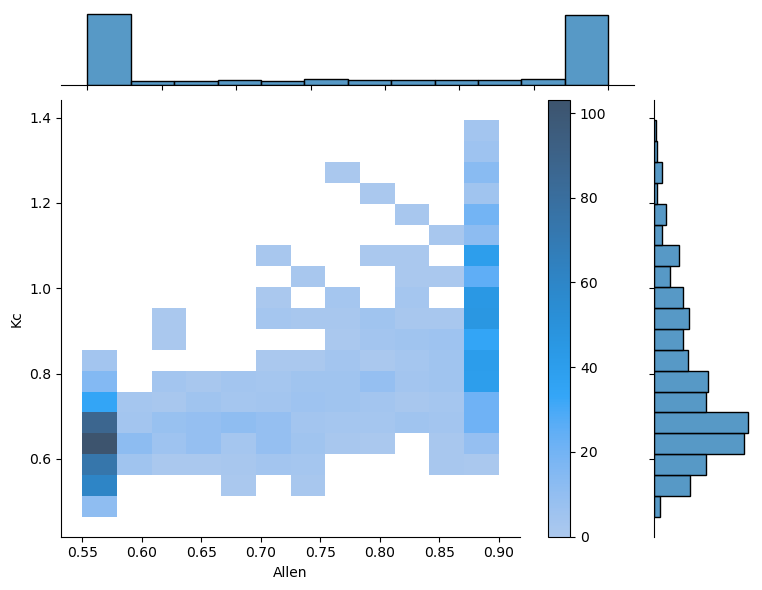

In [42]:
g = sns.jointplot(
    data, 
    x='Allen', 
    y='Kc',
    kind='hist',
    cbar=True,
)
g.fig.set_figwidth(8)

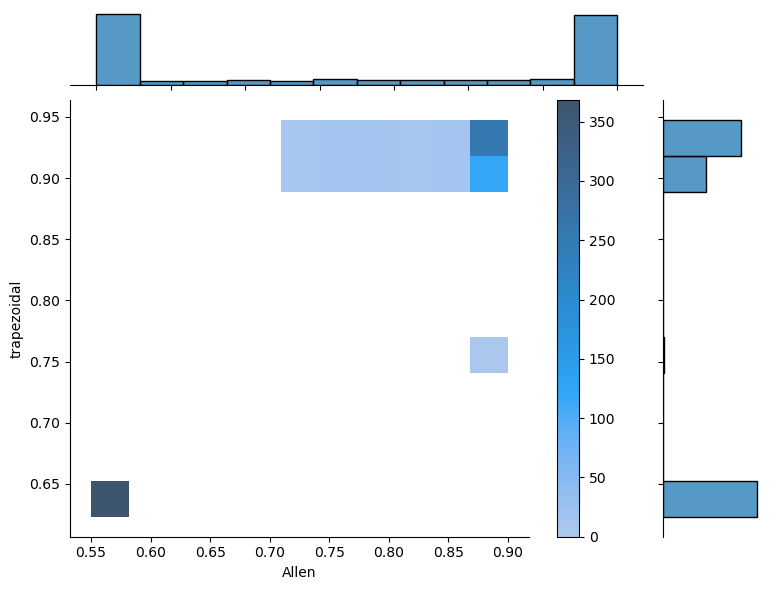

In [ ]:
g = sns.jointplot(data, 
              x='Allen', 
              y='trapezoidal', 
              cbar=True, 
              kind='hist',
)
g.fig.set_figwidth(8)

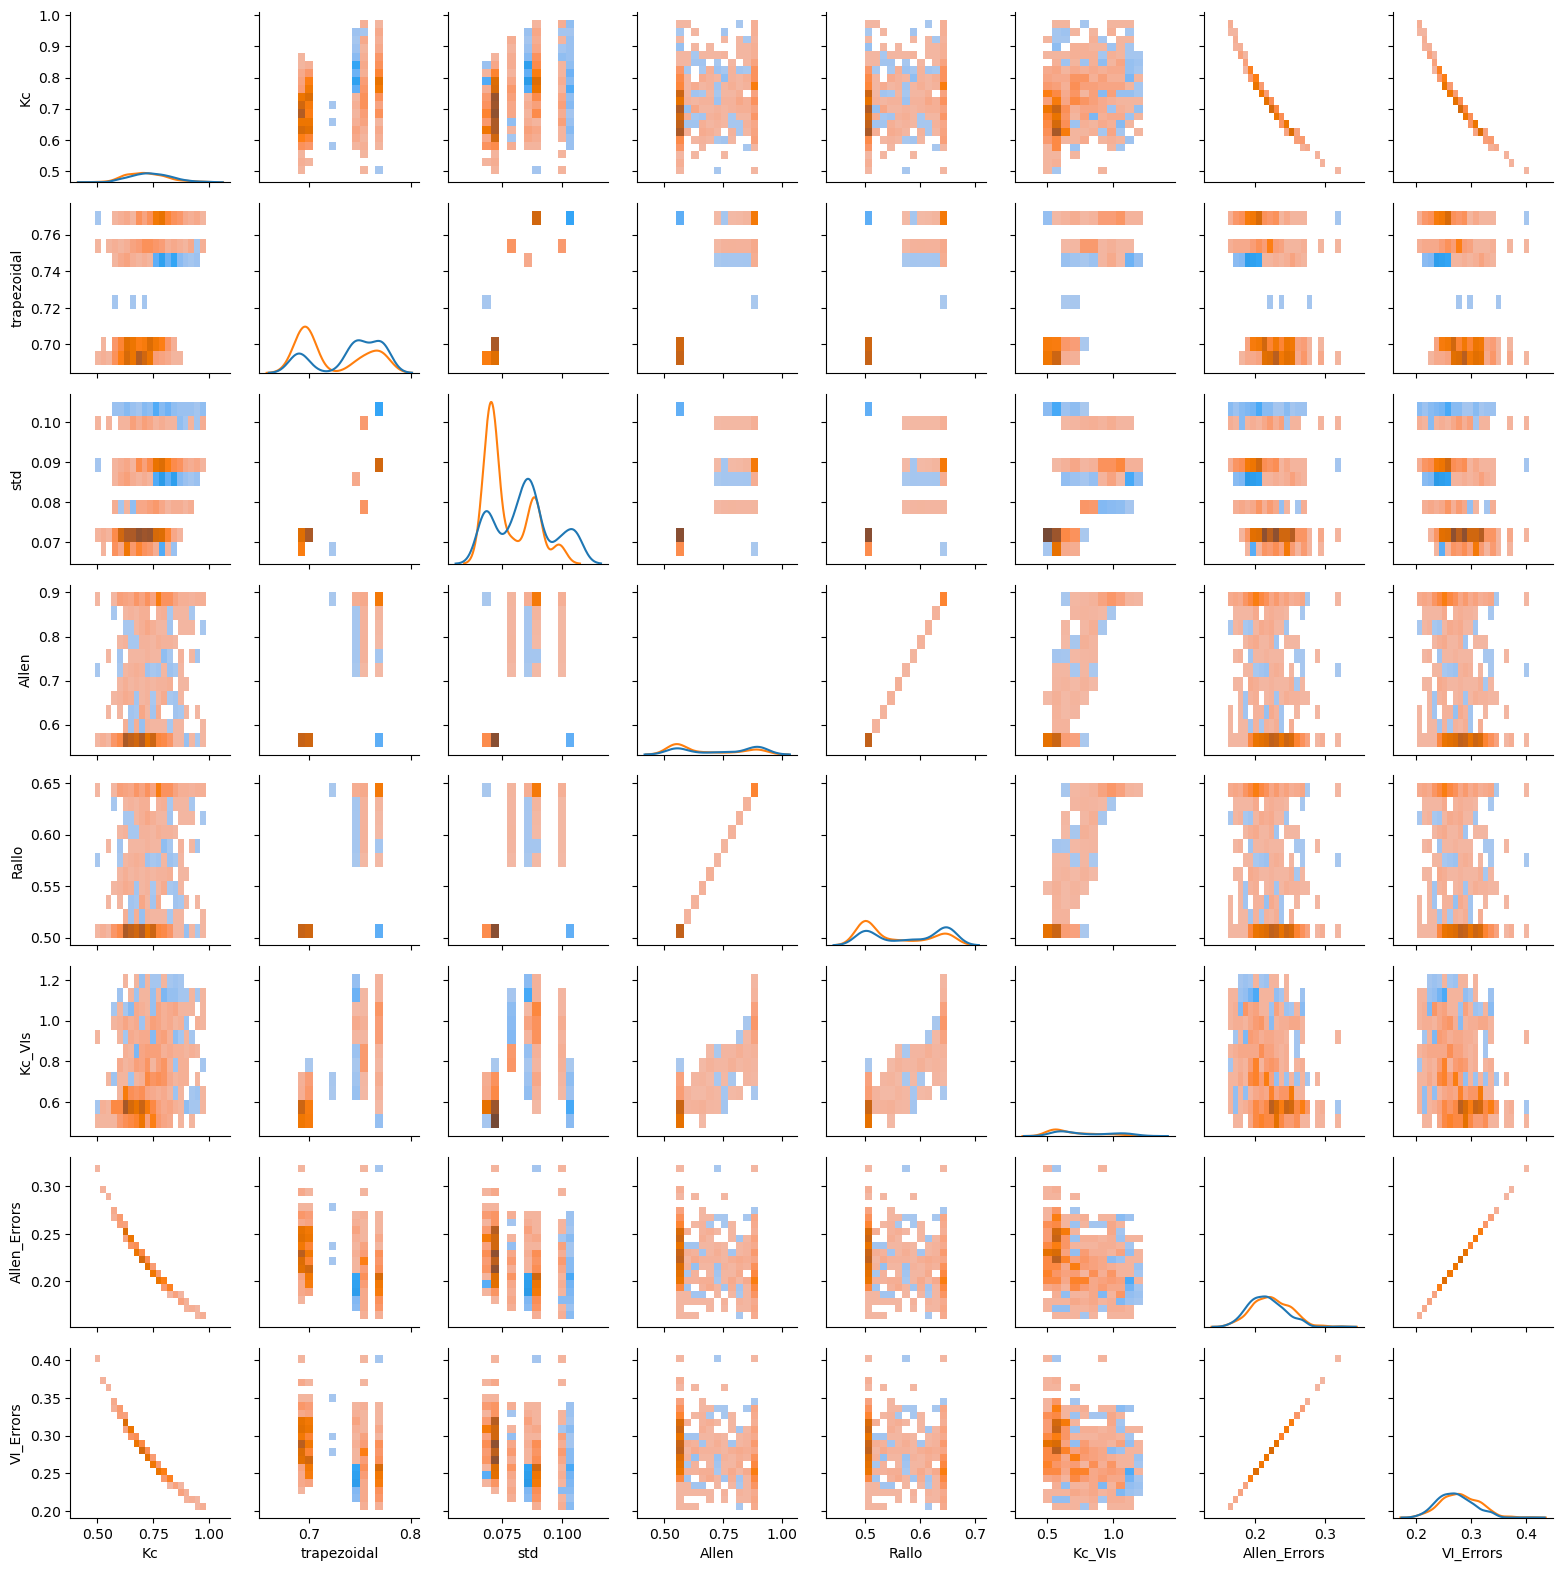

In [17]:
features = [col for col in data.columns if col != 'std']
g = sns.PairGrid(data, hue='Source', height=2)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.histplot)

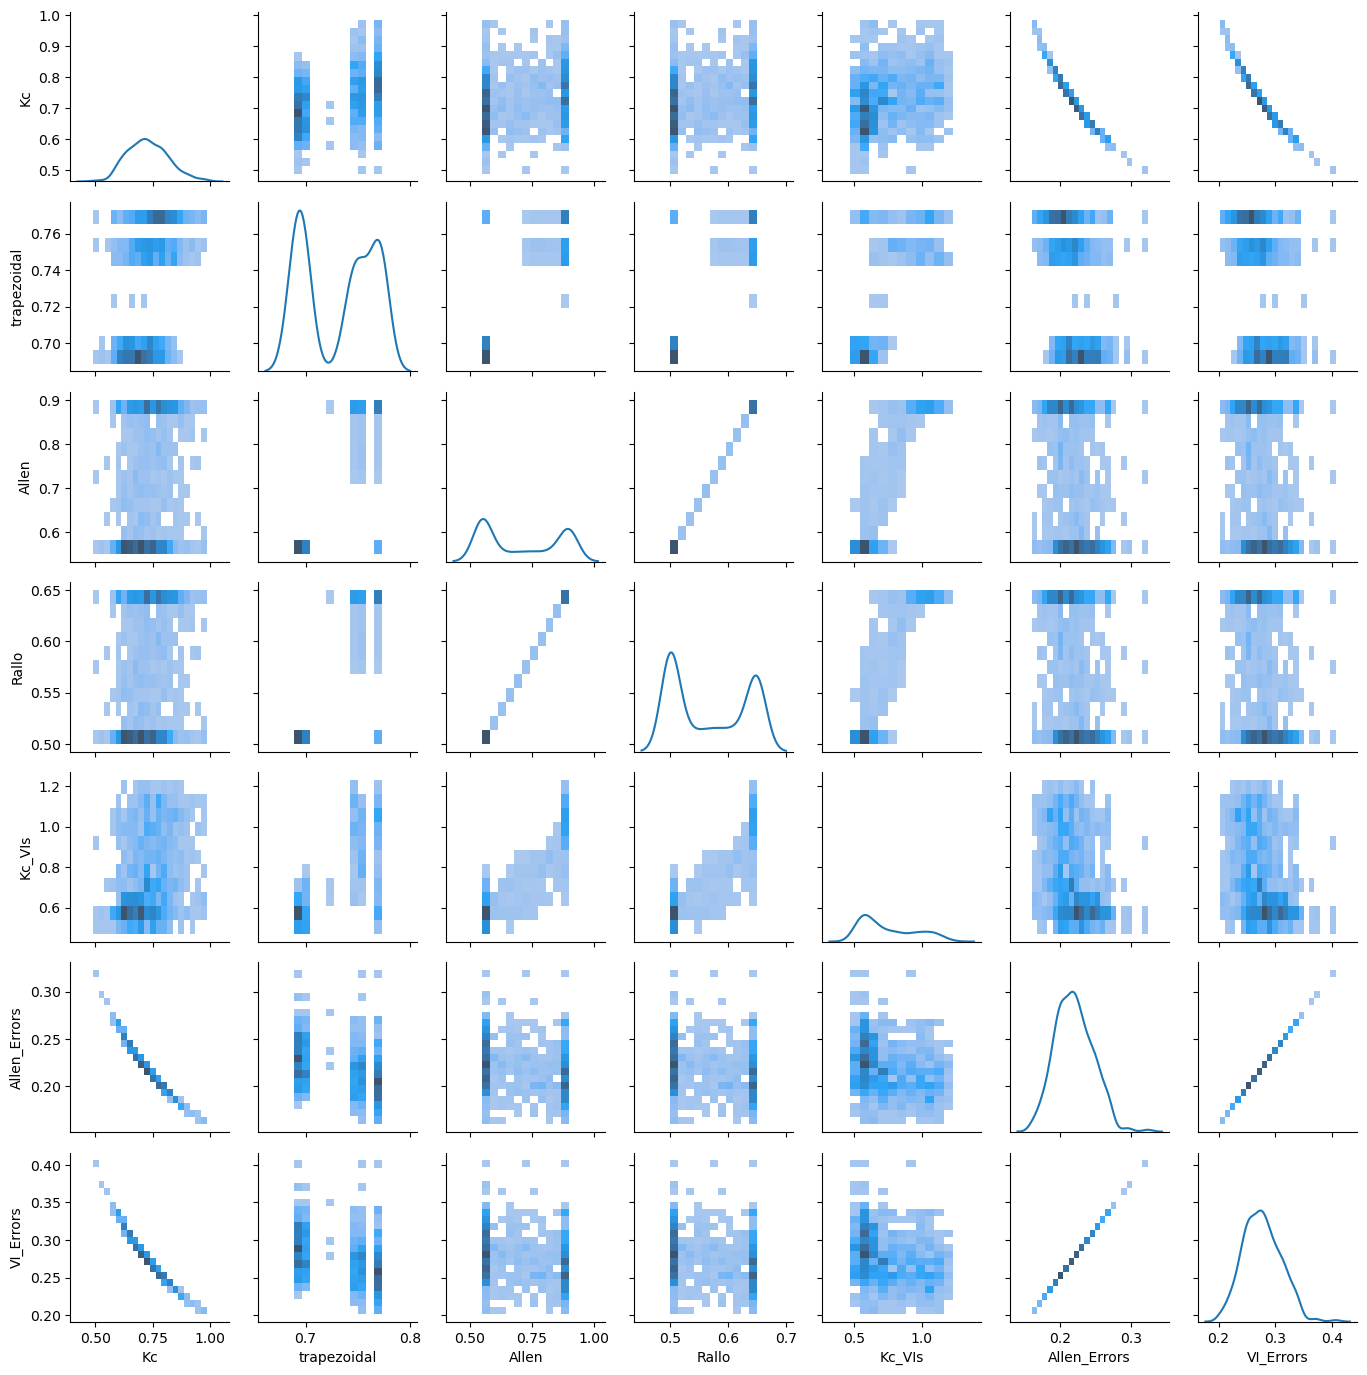

In [18]:
features = [col for col in data.columns if col not in ['std', 'Source']]
g = sns.PairGrid(data, height=2, vars=features)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.histplot)